# edu-cater 

In [1]:
# imports

import warnings
warnings.filterwarnings('ignore')

from selenium import webdriver
from bs4 import BeautifulSoup
import requests, os, sys, json, csv, copy, operator
from collections import Counter

import pandas as pd
import numpy as np
import pickle, time
import seaborn as sns
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # ???
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon


import pyLDAvis
from pyLDAvis import gensim as pyldagensim
from pyLDAvis import sklearn as pyldavis_sklearn

import networkx as nx
from networkx.algorithms import shortest_path

# add scripts directory to path
sys.path.insert(1, '../scripts/')
from edutools import *

[nltk_data] Downloading package wordnet to /home/amandae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# pipeline
run_pipeline = 0
scraper = course_scraper() 
scraper.load_urls()

if run_pipeline == 1:
    scraper.scrape_urls()  
    scraper.scrape_courses()
    scraper.scrape_course_network()

# Latent Dirichlet Allocation (LDA)

In [3]:
# define preprocessing functions: tokenization, stemming, lemmatization 
# based off of code from https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb

stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
stopwords.extend(['youâ', 'week', 'write', 'solv', 'peer', 'assign', 'beginn',
                  'need', 'peopl', 'content', 'teach', 'assess', 'plan', 'capston',
                  'video', 'lesson', 'think', 'idea', 'lectur', 'learner',
                 'quiz', 'test', 'submit', 'way', 'good', 'choos', 'begin', 'examin', 'colleg', 'academ', 'university', 'mooc',
                 'teacher', 'educ', 'classroom', 'want', 'materi', 'instruct', 'level', 'section'])

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    stem_dict = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopwords and lemmatize_stemming(token) not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
            stem_dict.append((lemmatize_stemming(token), token))
            
    return result, stem_dict

In [9]:
# aggregate all text info (description, syllabus) and preprocess

# remove courses that aren't in English (even though they had an English tag!)
all_courses = np.arange(2635)
bad_courses = np.array([661, 710, 919, 925, 949, 1701, 1714, 1717, 1723, 2398, 2612])
good_courses = np.setdiff1d(all_courses, bad_courses)

processed_info = []
nreviews = []
stars = []
hours = []
levels = []
enrollment = []
course_info_all = []
titles_all = []
skills_all = []
dict_stem_full = []

# some titles need to be fixed manually
correct_titles = {1197: 'Global Financing Solutions',
                 1672: 'Jacobi modular forms',
                 2166: 'Bioinformatics: Introduction and Methods',
                 2589: "Hôtel 'De l'étoile' - a hotel in crisis"}


# compile all relevant course info
for i in range(len(good_courses)):
    
    with open('../course_info_short/course' + str(good_courses[i]) + '.json') as json_file:
        course_info = json.load(json_file)
    
    title = course_info['title']
    if not isEnglish(title):
        title = fix_text(title)
    if i in correct_titles.keys():
        title = correct_titles[i]
    
    titles_all.append(title) 
    allinfo = title + ' ' + fix_text(course_info['description']) \
            + ' ' + fix_text(course_info['syllabus_headings']) + ' ' + fix_text(course_info['syllabus_descriptions']) 
    tmpskills = ''
    for skill in course_info['skills']:
        skill = fix_text(skill)
        tmpskills = tmpskills + ' ' + skill
    for occupation in course_info['occupations']:
        occupation = fix_text(occupation)
        allinfo = allinfo # + ' ' + occupation
    for review in course_info['reviews']:
        review = fix_text(review)
        allinfo = allinfo  # + ' ' + review
    nreviews.append(course_info['nreviews'])
    stars.append(course_info['stars'])
    hours.append(course_info['hours'])
    levels.append(course_info['level'])
    enrollment.append(course_info['enrollment']) 
    preprocessed, stemdict = preprocess(allinfo)
    processed_info.append(preprocessed)
    skills_all.append(preprocess(tmpskills)[0])
    course_info_all.append(allinfo)
    dict_stem_full.extend(stemdict)
    
# save course titles for web app
file = open('../edu-app/course_titles.pkl', 'wb')
pickle.dump(titles_all, file)
file.close()

# save numeric info
stars = np.array(stars)
hours = np.array(hours)
enrollment = np.array(enrollment)
# fix NaNs
hours[np.isnan(hours)==1] = np.nanmedian(hours)
stars[np.isnan(stars)==1] = np.nanmedian(stars)
savemat('../edu-app/course_numeric_info.mat', {'stars': stars, 'hours': hours, 'enrollment': enrollment})

file = open('../data/processed_info.pkl', 'wb')
pickle.dump([processed_info, skills_all, course_info_all, dict_stem_full], file)
file.close()

In [4]:
file = open('../data/processed_info.pkl', 'rb')
processed_info, skills_all, course_info_all, dict_stem_full = pickle.load(file)
file.close()

In [5]:
# make a dictionary with a) stemmed word and 
# b) lemmatized version of word most often associated with stemmed word

dict_stem_allfull = {}
for i in range(len(dict_stem_full)):
    if dict_stem_full[i][0] not in dict_stem_allfull.keys():
        dict_stem_allfull[dict_stem_full[i][0]] = []
    dict_stem_allfull[dict_stem_full[i][0]].append(dict_stem_full[i][1])
    
stemmed_words = list(dict_stem_allfull.keys())

dict_stem_maxword = {}
for stemmed in stemmed_words:
    word_counts = dict(Counter(dict_stem_allfull[stemmed]))
    maxword = max(word_counts.items(), key=operator.itemgetter(1))[0]
    dict_stem_maxword[stemmed] = WordNetLemmatizer().lemmatize(maxword, pos='v')
        

In [ ]:
# EDA for quantitative info
fig = plt.figure(figsize=(15,4))
fig.add_subplot(131)
plt.hist((np.array(stars)),20); plt.title('Rating')
fig.add_subplot(132)
plt.hist((hours),20); plt.title('Length (hours)')
fig.add_subplot(133)
plt.hist(np.log10(enrollment),20); plt.title('Enrollment (log10)')
plt.savefig('figures/course_numeric_info.png')
plt.show()

In [6]:
# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.25, keep_n=100000)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info] # 18819 3057

Length of original dictionary: 17432
Length of filtered dictionary: 3047


# determine optimal # of topics

In [7]:
countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = countvec.fit_transform(clean_text).todense()

In [91]:
def get_jensen_shannon(components, ntopics):
    topic_dists = components 
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))
                
    return np.min(js_dists), np.mean(js_dists)

def get_jaccard(components, ntopics):
    topn = int(np.ceil(len(dictionary)*(10/100)))
    topic_word_probs = components 
    top_terms = np.argsort(-1*topic_word_probs,axis=1)
    top_terms = 1*top_terms[:,0:topn]
    jdists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i > j:   
                jdists.append(jaccard(top_terms[i,:], top_terms[j,:]))
    return np.min(jdists), np.mean(jdists)

def avg_score(components, ntopics, ytrue=None):
    score1 = get_jensen_shannon(components, ntopics)[0]
    score2 = get_jaccard(components, ntopics)[0]
    return (score1 + score2)/2

class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score

In [ ]:
# try different numbers of topics

ntopics_list = [10, 11, 12, 13, 14, 15]
scores = []
for ntopics in ntopics_list:
    print(ntopics)
    lda_model = LDAwithCustomScore(random_state=0, n_components=ntopics)
    lda_model.fit_transform(X)
    scores.append(lda_model.score(X))
    
print(scores)

In [ ]:
# grid search CV with pipeline

# Define Search Param
ntopics_list = np.arange(10,26)
ntopics_list = [10, 15, 20]
search_params = {'n_components': ntopics_list}
lda = LDAwithCustomScore(random_state=0)

model = GridSearchCV(lda, param_grid=search_params, cv=1)
model.fit(X)

# Best Model
best_lda_model = model.best_estimator_

file = open('../data/sklearn_model_cv_test.pkl', 'wb')
pickle.dump(model,file)
file.close()

In [ ]:
if __name__=='__main__':
    with open('../data/sklearn_model_cv.pkl', 'rb') as f:
        model = pickle.load(f)

ntopics_list = np.arange(10,26)

cvmean = model.cv_results_['mean_test_score']
cvstd = model.cv_results_['std_test_score']

fs = 12
fig = plt.figure(figsize=(6,4))
plt.plot(ntopics_list, cvmean, c='#00aadd')
cvse = cvstd/np.sqrt(10)
plt.fill_between(ntopics_list, cvmean+cvse, cvmean-cvse, alpha=.2, color='#00aadd')
plt.legend(['Mean of CV scores', 'Std Err of CV scores'], loc='lower right')
plt.scatter(ntopics_list, cvmean, c='#00aadd')
plt.xlabel('# of topics', fontsize=fs)
plt.ylabel('Jensen-Shannon Divergence',fontsize=fs)
plt.gcf().subplots_adjust(bottom=.2)
plt.gcf().subplots_adjust(left=.2)
plt.savefig('figures/lda_sklearn_cv.png')
plt.show()
plt.errorbar(ntopics_list, cvmean, yerr=cvse); plt.show()

In [9]:
# re-define model using optimal # of topics

ntopics = 14
myseed = 0
pkg = 'sklearn'

if pkg == 'sklearn':
    lda_model = LDAwithCustomScore(random_state=myseed, n_components=ntopics)
    lda_model.fit_transform(X);
    data = pyldavis_sklearn.prepare(lda_model, X, countvec, mds = 'tsne', sort_topics=False)
elif pkg == 'gensim':
    lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary, 
                                        random_state=myseed, passes = 10, workers = 2, iterations=300)
    data = pyldagensim.prepare(lda_model, bow_corpus, dictionary, mds='tsne', sort_topics=False)
    
    

In [ ]:
# fix terms to be lemmatized most commonword instead of stemmed word
for row in range(len(data.topic_info.index)):
    if row%50 == 0:
        print(row)
    maxword = dict_stem_maxword[data.topic_info["Term"].iloc[row]]
    data.topic_info["Term"].iloc[row] = maxword

pyLDAvis.save_html(data,'../edu-app/static/courseviz.html')
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

# Uniqueness of topics

Use Jensen-Shannon divergence and Jaccard distance to determine how unique the topics are.

In [89]:
# jaccard
topn = int(np.ceil(len(dictionary)*(10/100)))
topic_word_probs = lda_model.components_
top_terms = np.argsort(-1*topic_word_probs,axis=1)
top_terms = top_terms[:,0:topn]
jdists = np.zeros((ntopics,ntopics))
for i in range(ntopics):
    for j in range(ntopics):  
        jdist = jaccard(top_terms[i,:], top_terms[j,:])
        jdists[i,j] = jdist

# jensen shannon distance
js_dists = np.zeros((ntopics,ntopics))
topic_dists = lda_model.components_
for i in range(ntopics):
    for j in range(ntopics):
        js_dists[i,j] = jensen_shannon(topic_dists[i,:], topic_dists[j,:])

Mean Jaccard distance: 0.8046879752997858
Mean JS distance: 0.4017700356257596


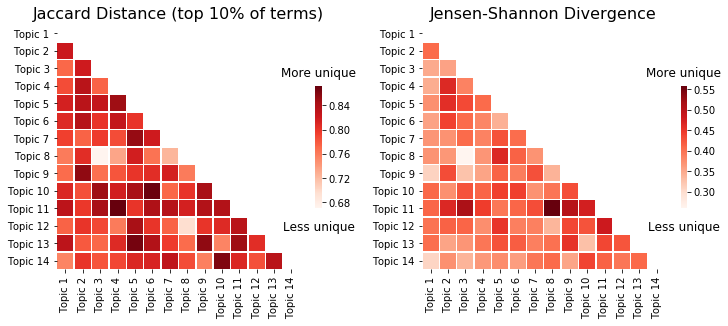

In [90]:
# plots

mask = np.zeros_like(jdists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_jdists = np.triu(jdists)
uptri_jdists = uptri_jdists[uptri_jdists>0]
print('Mean Jaccard distance:', np.mean(uptri_jdists))


uptri_js_dists = np.triu(js_dists)
uptri_js_dists = uptri_js_dists[uptri_js_dists>0]
print('Mean JS distance:', np.mean(uptri_js_dists))


def label_cbar(ax):
    cb = ax.collections[0].colorbar
    cb.ax.text(0.5, -0.1, 'Less unique', transform=cb.ax.transAxes, 
        va='top', ha='center', fontsize=12)
    cb.ax.text(0.5, 1.05, 'More unique', transform=cb.ax.transAxes, 
        va='bottom', ha='center', fontsize=12)

fig = plt.figure(figsize=(12,5))

fig.add_subplot(121)
ax = sns.heatmap(jdists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_jdists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
tick_labels = ['Topic ' + str(topic) for topic in np.arange(ntopics)+1]
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jaccard Distance (top 10% of terms)',fontsize=16)

fig.add_subplot(122)
ax = sns.heatmap(js_dists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_js_dists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jensen-Shannon Divergence', fontsize=16)

plt.gcf().subplots_adjust(bottom=.2)
plt.savefig('figures/topic_uniqueness.png')
plt.show()


# Similarity between topic scores

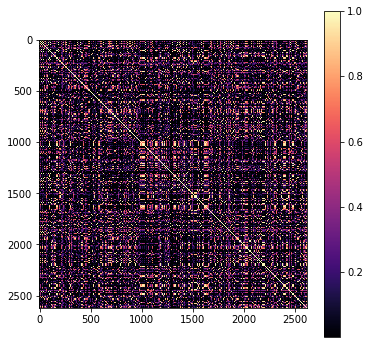

In [11]:
# similarity b/w topic scores 
    
scoremat = lda_model.transform(X)
savemat('../edu-app/scoremat.mat',{'scoremat': scoremat})

scorecorrs = cos_sim(scoremat)

fig = plt.figure(figsize=(6,6))
plt.imshow(scorecorrs, cmap='magma')
plt.colorbar()
plt.show()

In [ ]:
# distribution of best-matching topics

# this is how freqs are calculated in pyLDAvis code
doc_lengths = X.sum(axis=1).getA1()
doc_topic_dists = lda_model.transform(X)
topic_freq = np.dot(doc_topic_dists.T, doc_lengths) # (doc_topic_dists.T * doc_lengths).T.sum()
topic_proportion = (topic_freq / topic_freq.sum())

fig = plt.figure(figsize=(6,4))
plt.bar(np.arange(ntopics)+1, topic_proportion, color="#00aadd")
my_x_labels = []
for x in range(ntopics):
    my_x_labels.append('Topic ' + str(x+1))
plt.xticks(np.arange(ntopics)+1,my_x_labels, rotation=90)
#plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Marginal Topic Distribution')
plt.gcf().subplots_adjust(bottom=.3)
plt.savefig('figures/topicdist.png')
plt.show()

# Graph theory with networkx

In [ ]:
# graph theory with networkx

scorecorrs = cos_sim(scoremat)
scorecorrs_triu = np.triu(scorecorrs)
scorecorrs_triu = scorecorrs_triu[scorecorrs_triu>0]
thresh = np.percentile(scorecorrs_triu,92.5)
print(thresh)
scorecorrs[scorecorrs<=thresh] = 0

strength = np.sum(scorecorrs,0)
print('min strength:', np.min(strength))

G = nx.from_numpy_matrix(scorecorrs)
pos = nx.spring_layout(G)
weights = dict(G.degree(weight='weight'))
values = [weights.get(node, 0.25) for node in G.nodes()]
values_lda = copy.deepcopy(values)
values = np.argmax(doc_topic_dists,axis=1)

file = open('../edu-app/networkx_graph.pkl','wb')
pickle.dump(G, file)
file.close()

file = open('../edu-app/networkx_pos.pkl', 'wb')
pickle.dump(pos, file)
file.close()

file = open('../edu-app/networkx_values.pkl', 'wb')
pickle.dump(values, file)
file.close()

with open('../edu-app/static/nodes_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x', 'y', 'strength', 'radius','title'])
    for i in range(len(pos)):
        fwriter.writerow([pos[i][0], pos[i][1], int(values[i]), 2, titles_all[i]])

plt.figure(1,figsize=(10,10)) 
nx.draw(G, pos, node_size=20, node_color = values, width=.1, cmap='GnBu', edge_color = "#222222")
plt.savefig("figures/coursera_lda_network.png", format="PNG")
plt.show(block=False)

# write edges.csv: saved edges are for visualization only (higher threshold)
list_edges = list(G.edges())
with open('../edu-app/static/edges_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
    for i in range(len(list_edges)):
        if list_edges[i][0] != list_edges[i][1]:
            x1 = pos[list_edges[i][0]][0]
            x2 = pos[list_edges[i][1]][0]
            y1 = pos[list_edges[i][0]][1]
            y2 = pos[list_edges[i][1]][1]
            fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])

In [ ]:
# use a higher threshold for visualization purposes only (looks much nicer!)

thresh = np.percentile(scorecorrs_triu,97.5)
scorecorrs = cos_sim(scoremat)
scorecorrs[scorecorrs<=thresh] = 0
strength = np.sum(scorecorrs, axis=0)
strength_thresh = 15
inds = np.where(strength<=strength_thresh)[0]
print(len(inds))

G = nx.from_numpy_matrix(scorecorrs)
for ind in inds:
    G.remove_node(ind)

graphs = list(nx.connected_component_subgraphs(G))
graph_sizes = []
for graph in graphs:
    graph_sizes.append(len(graph.nodes()))
    
best_ind = np.where(graph_sizes==np.max(graph_sizes))[0][0]
bestgraph = graphs[best_ind]

G = bestgraph 

values_thresh = copy.deepcopy(np.array(values))
#values_thresh = values_thresh[np.where(strength>strength_thresh)[0]]
newnodes = list(bestgraph.nodes())
values_thresh = values_thresh[newnodes]

plt.figure(1,figsize=(10,10)) 
nx.draw(G, pos, node_size=20, node_color = values_thresh, width=.1, cmap='GnBu', vmin = np.min(values), edge_color="#222222")
plt.savefig("figures/coursera_lda_network_thresh.png", format="PNG")
plt.show(block=False)

# write nodes for plotting (viz only)
with open('../edu-app/static/nodes_orig_plot.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x', 'y', 'strength', 'radius','title'])
    for i in range(len(pos)):
        if i in G.nodes():
            fwriter.writerow([pos[i][0], pos[i][1], int(values[i]), 2, titles_all[i]])

# write edges.csv: saved edges are for visualization only (higher threshold)
list_edges = list(G.edges())
with open('../edu-app/static/edges_orig_plot.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
    for i in range(len(list_edges)):
        if list_edges[i][0] != list_edges[i][1]:
            x1 = pos[list_edges[i][0]][0]
            x2 = pos[list_edges[i][1]][0]
            y1 = pos[list_edges[i][0]][1]
            y2 = pos[list_edges[i][1]][1]
            fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])

# Validate the LDA model

## compare to coursera's recommendation graph

In [ ]:
# make binary graph: rows = course being viewed; cols = courses that are recommended
ncourses = len(titles_all)
coursenet_full = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    mat = loadmat('../course_nets/course'+str(good_courses[i])+'.mat')
    coursenet = mat['coursenet']
    coursenet = coursenet[:,good_courses][0]
    coursenet_full[i,:] = coursenet
    inds = np.where(coursenet_full[i,:]==1.0)[0]
    
    
# topic-topic similarity for courses that are recommended by coursera
coursenet_sim = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    for j in range(ncourses):
        scores1 = scoremat[i,:]
        scores2 = scoremat[j,:]
        if coursenet_full[i,j] == 1:
            coursenet_sim[i,j] = cos_sim(scores1[:,np.newaxis].T,scores2[:,np.newaxis].T)[0][0]
            

In [ ]:
# make a graph based on Coursera's recommendations

G = nx.from_numpy_matrix(coursenet_sim)
nx.from_numpy_matrix
weights = dict(G.degree(weight='weight'))
values = np.array([weights.get(node, 0.25) for node in G.nodes()])
values_recs = copy.deepcopy(values)
print(np.sum(values==1))
file = open('../edu-app/networkx_pos.pkl','rb')
pos = pickle.load(file)
file.close()

pos_new = nx.spring_layout(G, pos=pos, iterations=2, seed=100)

plt.figure(1,figsize=(8, 8)) 
nx.draw(G, pos_new, node_size=20, node_color=values, width=.1, cmap='GnBu', vmin=-30)
plt.savefig("figures/coursera_rec_network.png", format="PNG")
plt.show(block=False)

In [ ]:
# compare node strength for lda and orig recs

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.hist(values_lda)
plt.title('Node Strength: edu-cater', fontsize=16)
fig.add_subplot(122)
plt.hist(values_recs)
plt.title('Node Strength: Coursera', fontsize=16)
plt.savefig('figures/node_strength.png')
plt.show()

## How is the LDA model better than Coursera's current recommendation system?

1) The cosine similarity between topic scores for a document (used to train the model) and topic scores from skills tags (not used in model training) is high. Thus, the topics generated from LDA are valid.  

2) However, for a given course, the overlap between the skills tags and the top 10 terms from the most relevant topic is low (max 4/10). Thus, the topics provide more information than the skills tags alone.  

These features are demonstrated with the code below.

In [63]:
def get_course_skills_scores(ind): 
    
    unseen_document = course_info_all[ind]
    preprocessed = preprocess(unseen_document)[0]
    preprocessed = ' '.join(list(preprocessed))
    textlist = []
    textlist.append(preprocessed)
    X = countvec.transform(textlist).todense()        
    course_topic_scores = lda_model.transform(X)
    
    unseen_document = skills_all[ind]
    unseen_document = ' '.join(unseen_document)
    preprocessed = preprocess(unseen_document)[0]
    preprocessed = ' '.join(list(preprocessed))
    textlist = []
    textlist.append(preprocessed)
    X = countvec.transform(textlist).todense()        
    skills_topic_scores = lda_model.transform(X)
        
    return course_topic_scores[0], skills_topic_scores[0]


def get_course_skills_sim():
    for i in range(len(skills_all)):
        if i%100 == 0:
            print(i)

        # not all courses have skills tags
        if len(skills_all[i])>0:
            course_scores, skills_scores = get_course_skills_scores(i)
            cs_sim = cos_sim(course_scores, skills_scores)[0][0]
            course_skills_sim.append(cs_sim)

            skills = set(skills_all[i])
            best_topic = np.argmax(course_scores)
            topic_terms = lda_model.get_topic_terms(best_topic, topn=30)
            top_terms = []
            for x in range(len(topic_terms)):
                top_terms.append(dictionary[topic_terms[x][0]])

            counter = 0
            for term in top_terms:
                if term in skills:
                    counter +=1
            topterms_in_skills.append(counter)
        
    return topterms_in_skills
    

In [87]:
course_skills_sim = []
topterms_in_skills = []
topn = 30

allterms = countvec.get_feature_names()

for i in range(len(skills_all)):
    
    # not all courses have skills tags
    if len(skills_all[i])>0:
        course_scores, skills_scores = get_course_skills_scores(i)
        cs_sim = cos_sim(course_scores.reshape(-1,1).T, skills_scores.reshape(-1,1).T)[0][0]
        course_skills_sim.append(cs_sim)
        
        skills = list(set(skills_all[i]))
        best_topic = np.argmax(course_scores)
        
        topic_word_probs = lda_model.components_[best_topic,:]
        top_terms = np.argsort(-1*topic_word_probs)
        top_terms = top_terms[0:topn]
        
        top_terms = [allterms[t] for t in top_terms]
            
        counter = 0
        for term in top_terms:
            if term in skills:
                counter +=1
        topterms_in_skills.append(counter)

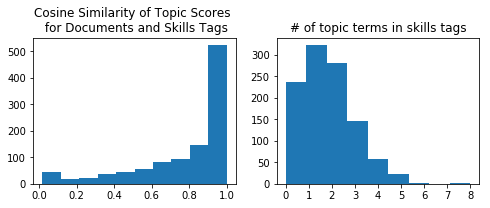

1069 courses had skills tags
Median similarity between document scores and topic scores: 0.8956765530541936
Median number of skills tag terms present in top 10 terms: 1.0


In [88]:
# plots to show similarity and overlap

fig = plt.figure(figsize=(8,3))
fig.add_subplot(121); plt.hist(course_skills_sim); 
plt.title('Cosine Similarity of Topic Scores \n for Documents and Skills Tags')
fig.add_subplot(122); plt.hist(topterms_in_skills,np.max(topterms_in_skills)+1);
plt.xticks(np.arange(np.max(topterms_in_skills)+1))
plt.title('# of topic terms in skills tags')
plt.gcf().subplots_adjust(top=.80)
plt.savefig('figures/validation1.png')
plt.show()
print(len(course_skills_sim), 'courses had skills tags')
print('Median similarity between document scores and topic scores:',np.median(course_skills_sim))
print('Median number of skills tag terms present in top 10 terms:',np.median(topterms_in_skills))

# example graph to illustrate shortest path

In [ ]:
g2 = nx.Graph()
g2.add_edge(4, 2, weight=5)
g2.add_edge(2, 3, weight=2)
g2.add_edge(4, 5, weight=3)
g2.add_edge(2, 1, weight=1)
g2.add_edge(3, 5, weight=1)

strength = dict(g2.degree(weight='weight'))
values = [strength.get(node, 0.25) for node in g2.nodes()]
weights = [g2[u][v]['weight'] for u,v in g2.edges]

pos = nx.spring_layout(g2, weight=None)

fig = plt.figure(figsize=(4,2))
nx.draw(g2, pos, width=weights, node_size=1200, node_color=values, cmap='jet', vmin=-3, vmax=10, with_labels=True)
shortest_path(g2,1,5,weight="weight")
plt.savefig('figures/shortpath_example.png')